Epoch [1/10], Train Loss: 0.7278, Val Loss: 0.6347
Epoch [2/10], Train Loss: 0.6079, Val Loss: 0.5849
Epoch [3/10], Train Loss: 0.5736, Val Loss: 0.4831
Epoch [4/10], Train Loss: 0.5398, Val Loss: 0.4997
Epoch [5/10], Train Loss: 0.5176, Val Loss: 0.5071
Epoch [6/10], Train Loss: 0.4906, Val Loss: 0.4965
Early stopping triggered.
Test Accuracy: 55.00%
Precision: 53.12%, Recall: 85.00%, F1 Score: 65.38%


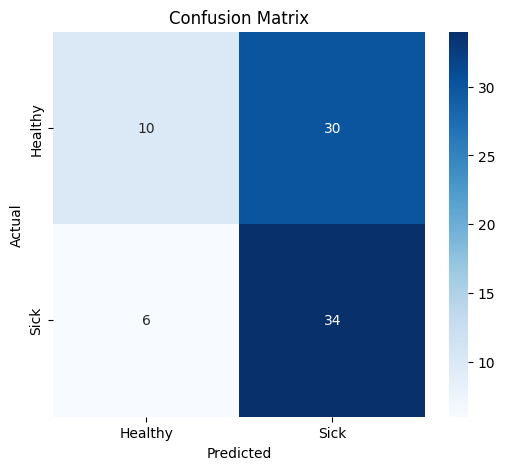

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transformations (including augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define directories
train_dir = "train"
test_dir = "test"

# Load Dataset
full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained ResNet Model & Modify
def create_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False  # Freeze base layers
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 2)
    )
    return model.to(device)

model = create_model()

# Loss, Optimizer, & Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training Loop with Early Stopping
early_stop_patience = 3
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Load Best Model for Testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Testing
correct = 0
total = 0
all_preds, all_labels = [], []
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

with torch.no_grad():
    for filename in test_images:
        file_path = os.path.join(test_dir, filename)
        image = datasets.folder.default_loader(file_path)
        image = transform(image).unsqueeze(0).to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        actual_label = 1 if filename.startswith("S_") else 0
        all_preds.append(predicted.item())
        all_labels.append(actual_label)

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}, Recall: {recall:.2%}, F1 Score: {f1:.2%}")

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [6]:
import pandas as pd
import torch
import os
from torchvision.datasets.folder import default_loader

def create_predictions_csv(model, test_dir, transform, device, output_csv="predictions.csv"):
    """
    Generate a CSV file with predictions for test images.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        test_dir (str): Directory containing test images.
        transform (torchvision.transforms.Compose): Transformations applied to the images.
        device (torch.device): The device (CPU/GPU) to run the model on.
        output_csv (str): Name of the output CSV file.
    """
    model.eval()
    predictions = []
    
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    with torch.no_grad():
        for filename in test_images:
            file_path = os.path.join(test_dir, filename)

            # Load and preprocess image
            image = default_loader(file_path)  # Load using PIL
            image = transform(image).unsqueeze(0).to(device)  # Apply transform & add batch dimension
            
            # Get prediction
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()  # 0 = Healthy, 1 = Sick
            
            # Store result
            predictions.append([filename, predicted_label])
    
    # Save to CSV
    df = pd.DataFrame(predictions, columns=["File Name", "Output Label"])
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

# Example usage:
# create_predictions_csv(model, "test", transform, device)
create_predictions_csv(model, test_dir, transform, device, output_csv="predictions.csv")

Predictions saved to predictions.csv


In [5]:
import pandas as pd
import torch
import os
from torchvision.datasets.folder import default_loader

def create_predictions_csv(model, test_dir, transform, device, output_folder="output", output_filename="predictions.csv"):
    """
    Generate a CSV file with predictions for test images.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        test_dir (str): Directory containing test images.
        transform (torchvision.transforms.Compose): Transformations applied to the images.
        device (torch.device): The device (CPU/GPU) to run the model on.
        output_folder (str): Directory where the CSV file will be saved.
        output_filename (str): Name of the output CSV file.
    """
    model.eval()
    predictions = []
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all test images
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    with torch.no_grad():
        for filename in test_images:
            file_path = os.path.join(test_dir, filename)

            # Load and preprocess image
            image = default_loader(file_path)  # Load using PIL
            image = transform(image).unsqueeze(0).to(device)  # Apply transform & add batch dimension
            
            # Get prediction
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()  # 0 = Healthy, 1 = Sick
            
            # Store result
            predictions.append([filename, predicted_label])
    
    # Save to CSV
    output_csv_path = os.path.join(output_folder, output_filename)
    df = pd.DataFrame(predictions, columns=["File Name", "Output Label"])
    df.to_csv(output_csv_path, index=False)
    
    print(f"Predictions saved to: {output_csv_path}")

# Example usage:
# create_predictions_csv(model, "test", transform, device)


In [3]:
import pandas as pd
import torch
import os
from torchvision.datasets.folder import default_loader

def create_predictions_csv(model, test_dir, transform, device, output_csv="predictions.csv"):
    """
    Generate a CSV file with predictions for test images.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        test_dir (str): Directory containing test images.
        transform (torchvision.transforms.Compose): Transformations applied to the images.
        device (torch.device): The device (CPU/GPU) to run the model on.
        output_csv (str): Name of the output CSV file.
    """
    model.eval()
    predictions = []
    
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    with torch.no_grad():
        for filename in test_images:
            file_path = os.path.join(test_dir, filename)

            # Load and preprocess image
            image = default_loader(file_path)  # Load using PIL
            image = transform(image).unsqueeze(0).to(device)  # Apply transform & add batch dimension
            
            # Get prediction
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()  # 0 = Healthy, 1 = Sick
            
            # Store result
            predictions.append([filename, predicted_label])
    
    # Save to CSV
    df = pd.DataFrame(predictions, columns=["File Name", "Output Label"])
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

# Example usage
# create_predictions_csv(model, "test", transform, device)
